In [1]:
using CSV
using DataFrames
using Flux
using HypothesisTests
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

include("../helpers_temp.jl")
include("../stats_temp.jl")

updatescoresdict! (generic function with 1 method)

In [2]:
train_new_model = true

true

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [5]:
x_df = decorrelatedvars(x_df);
x_df, _ = minmaxscaledf(x_df);
y_df, y_scalers = minmaxscaledf(y_df);

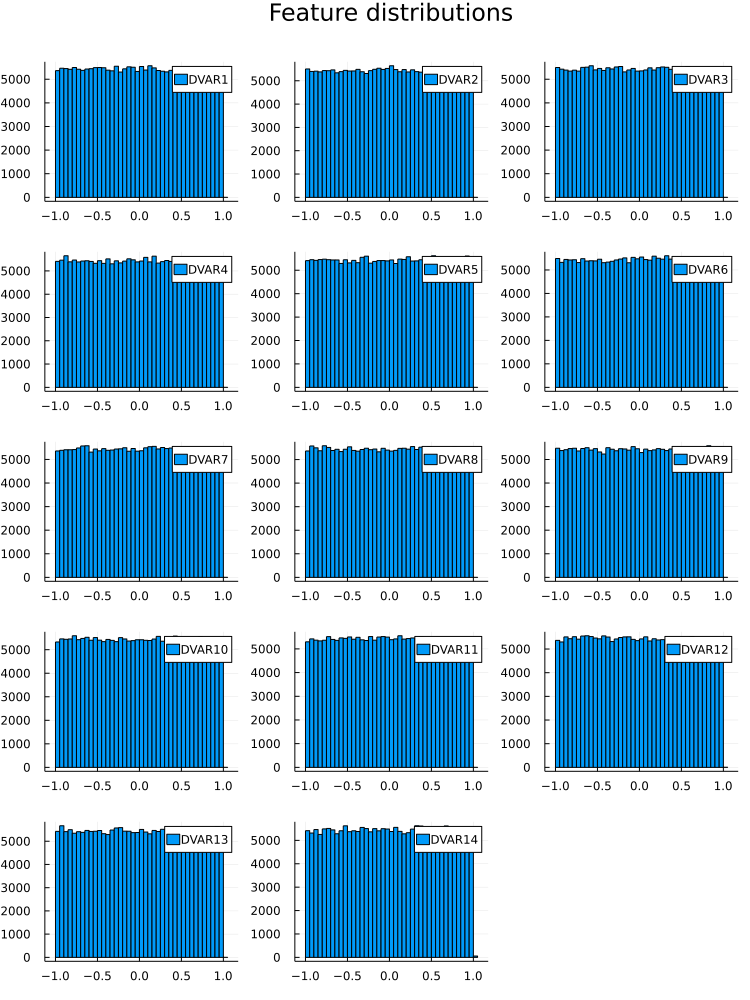

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

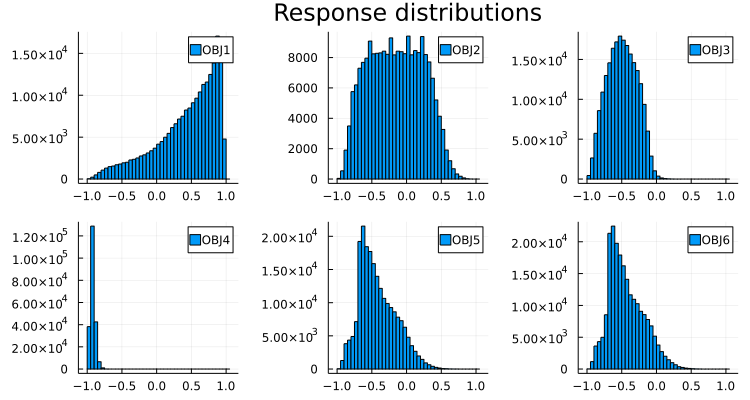

In [8]:
# plot features
l = @layout [grid(2, 3)]

subplots = []
for i in 1:6
    hist = histogram(y_df[:, "OBJ$i"], label="OBJ$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 400), plot_title="Response distributions")

In [7]:
x_train_df, x_test_df, y_train_df, y_test_df = traintestsplit(x_df, y_df; read_in=true, path="../indexes/")

x_train = Float32.(Matrix(x_train_df));
x_test = Float32.(Matrix(x_test_df));
y_train = Float32.(Matrix(y_train_df));
y_test = Float32.(Matrix(y_test_df));

- Using preexisting train and test sets


In [8]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [9]:
# build the model
depth = 6
width = 75
function neuralnetwork()
    Chain(
        Dense(x_dimension, width, x->σ.(x)),
        (Dense(width, width, x->σ.(x)) for _ in 1:depth)...,
        Dense(width, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [10]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [11]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]
    training_times = Float32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        start_time = time()
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        end_time = time()
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
        push!(training_times, Float32(end_time - start_time))
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "trained_nn.bson" m
end

epoch 1, loss=14.775973655283451
epoch 2, loss=12.14666710793972
epoch 3, loss=5.92200081422925
epoch 4, loss=4.661952577531338
epoch 5, loss=3.902393026277423
epoch 6, loss=2.4821483362466097
epoch 7, loss=2.047955865971744
epoch 8, loss=1.8575791148468852
epoch 9, loss=1.7732015307992697
epoch 10, loss=1.7288979962468147
epoch 11, loss=1.6509694559499621
epoch 12, loss=1.626588374376297
epoch 13, loss=1.5904155541211367
epoch 14, loss=1.608175010420382
epoch 15, loss=1.5324711771681905
epoch 16, loss=1.497263727709651
epoch 17, loss=1.4967895625159144
epoch 18, loss=1.4513410357758403
epoch 19, loss=1.4476741612888873
epoch 20, loss=1.431065703742206
epoch 21, loss=1.4085005884990096
epoch 22, loss=1.4034538576379418
epoch 23, loss=1.376493249554187
epoch 24, loss=1.3856592159718275
epoch 25, loss=1.361258324701339
epoch 26, loss=1.3366445237770677
epoch 27, loss=1.369208733085543
epoch 28, loss=1.3246638448908925
epoch 29, loss=1.298019152134657
epoch 30, loss=1.30107091832906
epoch

epoch 473, loss=0.9071283671073616
epoch 474, loss=0.9036108697764575
epoch 475, loss=0.9113226165063679
epoch 476, loss=0.8972729998640716
epoch 477, loss=0.9071315410546958
epoch 478, loss=0.8966304007917643
epoch 479, loss=0.9075787635520101
epoch 480, loss=0.8958071409724653
epoch 481, loss=0.8923482964746654
epoch 482, loss=0.9020268097519875
epoch 483, loss=0.9050900000147521
epoch 484, loss=0.8987187184393406
epoch 485, loss=0.9058407284319401
epoch 486, loss=0.9047060650773346
epoch 487, loss=0.8976091155782342
epoch 488, loss=0.9179591299034655
epoch 489, loss=0.8979540565051138
epoch 490, loss=0.904199524782598
epoch 491, loss=0.8983073960989714
epoch 492, loss=0.8945326046086848
epoch 493, loss=0.8997385492548347
epoch 494, loss=0.8950079935602844
epoch 495, loss=0.900281164329499
epoch 496, loss=0.8958462341688573
epoch 497, loss=0.8974400940351188
epoch 498, loss=0.8914550221525133
epoch 499, loss=0.903048531152308
epoch 500, loss=0.9012472028844059
epoch 501, loss=0.89179

epoch 941, loss=0.8509914013557136
epoch 942, loss=0.8418736876919866
epoch 943, loss=0.846087921410799
epoch 944, loss=0.8499764269217849
epoch 945, loss=0.8450944484211504
epoch 946, loss=0.8421135996468365
epoch 947, loss=0.8400446730665863
epoch 948, loss=0.8399390517733991
epoch 949, loss=0.8395407604984939
epoch 950, loss=0.8392521939240396
epoch 951, loss=0.8463789126835763
epoch 952, loss=0.8428460033610463
epoch 953, loss=0.8390125697478652
epoch 954, loss=0.8427989669144154
epoch 955, loss=0.8427934600040317
epoch 956, loss=0.847599153406918
epoch 957, loss=0.8426597896032035
epoch 958, loss=0.8411537138745189
epoch 959, loss=0.8469438292086124
epoch 960, loss=0.839118477422744
epoch 961, loss=0.8469327325001359
epoch 962, loss=0.8408203711733222
epoch 963, loss=0.8484047926031053
epoch 964, loss=0.8378939786925912
epoch 965, loss=0.8474847474135458
epoch 966, loss=0.8460283800959587
epoch 967, loss=0.8517305008135736
epoch 968, loss=0.8512443141080439
epoch 969, loss=0.84243

epoch 1171, loss=0.8230431559495628
epoch 1172, loss=0.8401098721660674
epoch 1173, loss=0.8353330134414136
epoch 1174, loss=0.8264653887599707
epoch 1175, loss=0.8177706068381667
epoch 1176, loss=0.824088697321713
epoch 1177, loss=0.8218658827245235
epoch 1178, loss=0.8265522085130215
epoch 1179, loss=0.8177213766612113
epoch 1180, loss=0.8230410078540444
epoch 1181, loss=0.8236668854951859
epoch 1182, loss=0.8180314558558166
epoch 1183, loss=0.8203360759653151
epoch 1184, loss=0.8299664095975459
epoch 1185, loss=0.8218368818052113
epoch 1186, loss=0.8233914109878242
epoch 1187, loss=0.8228558311238885
epoch 1188, loss=0.8206135188229382
epoch 1189, loss=0.818938291631639
epoch 1190, loss=0.8201030767522752
epoch 1191, loss=0.8198880078271031
epoch 1192, loss=0.821633093059063
epoch 1193, loss=0.8224051017314196
epoch 1194, loss=0.8200240693986416
epoch 1195, loss=0.8237958764657378
epoch 1196, loss=0.8196017220616341
epoch 1197, loss=0.8187768682837486
epoch 1198, loss=0.834188493434

epoch 1627, loss=0.7967422846704721
epoch 1628, loss=0.7979058790951967
epoch 1629, loss=0.7902461346238852
epoch 1630, loss=0.7993541276082397
epoch 1631, loss=0.7899038083851337
epoch 1632, loss=0.8003209917806089
epoch 1633, loss=0.7938385051675141
epoch 1634, loss=0.7911076340824366
epoch 1635, loss=0.797521211206913
epoch 1636, loss=0.7947936286218464
epoch 1637, loss=0.7922499692067504
epoch 1638, loss=0.7992939334362745
epoch 1639, loss=0.7968282359652221
epoch 1640, loss=0.79275693744421
epoch 1641, loss=0.8014386775903404
epoch 1642, loss=0.7920328774489462
epoch 1643, loss=0.7944248816929758
epoch 1644, loss=0.7965438570827246
epoch 1645, loss=0.7898572529666126
epoch 1646, loss=0.7912103272974491
epoch 1647, loss=0.7931218012236059
epoch 1648, loss=0.7896716552786529
epoch 1649, loss=0.7897998648695648
epoch 1650, loss=0.8045680727809668
epoch 1651, loss=0.788096347823739
epoch 1652, loss=0.7912192107178271
epoch 1653, loss=0.788935923948884
epoch 1654, loss=0.78966505173593

epoch 2083, loss=0.773840265814215
epoch 2084, loss=0.7713638180866838
epoch 2085, loss=0.7764163319952786
epoch 2086, loss=0.7730197347700596
epoch 2087, loss=0.7721356586553156
epoch 2088, loss=0.7698268452659249
epoch 2089, loss=0.7778965062461793
epoch 2090, loss=0.7701316545717418
epoch 2091, loss=0.7750322730280459
epoch 2092, loss=0.7706794166006148
epoch 2093, loss=0.7748316270299256
epoch 2094, loss=0.775879381224513
epoch 2095, loss=0.7736916798166931
epoch 2096, loss=0.7704334342852235
epoch 2097, loss=0.7722882214002311
epoch 2098, loss=0.7710454082116485
epoch 2099, loss=0.7714954493567348
epoch 2100, loss=0.7765000290237367
epoch 2101, loss=0.7743116030469537
epoch 2102, loss=0.7740525370463729
epoch 2103, loss=0.7694196021184325
epoch 2104, loss=0.7801516046747565
epoch 2105, loss=0.7744449148885906
epoch 2106, loss=0.7712392676621675
epoch 2107, loss=0.77703025797382
epoch 2108, loss=0.772441120352596
epoch 2109, loss=0.7759428583085537
epoch 2110, loss=0.77757225837558

In [12]:
# write out training time information
save_training_times = true
if save_training_times
    CSV.write("../results/timing_results/julia_cpu_d5_w100.csv", DataFrame(col1 = training_times));
end

"../results/timing_results/julia_cpu_d5_w100.csv"

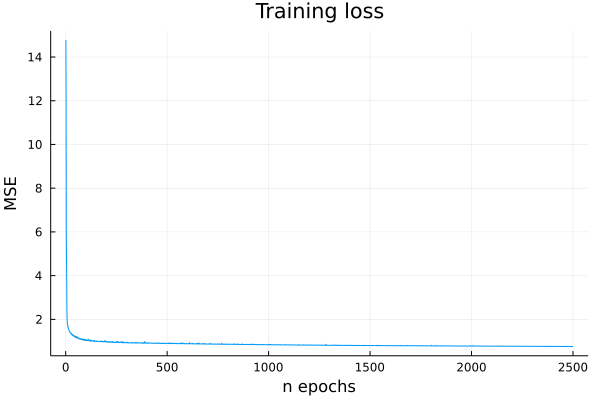

In [13]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [14]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [15]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.93035764
r2 on test set: 0.9283099


In [16]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [17]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.930352
adjustedr2 on test set: 0.92828673


In [18]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.043556266
mae on test set: 0.04477147


In [19]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.015858518
mae on test set for OBJ1: 0.016755404
mae on training set for OBJ2: 0.07426824
mae on test set for OBJ2: 0.075429074
mae on training set for OBJ3: 0.00962162
mae on test set for OBJ3: 0.009716995
mae on training set for OBJ4: 0.0057287836
mae on test set for OBJ4: 0.00579795
mae on training set for OBJ5: 0.08005826
mae on test set for OBJ5: 0.08260467
mae on training set for OBJ6: 0.07580215
mae on test set for OBJ6: 0.0783247


In [20]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [21]:
y_scalers

Dict{String, MinMaxScaler} with 6 entries:
  "OBJ4" => MinMaxScaler(0.00582, 1.34901)
  "OBJ6" => MinMaxScaler(0.00697, 0.10912)
  "OBJ2" => MinMaxScaler(0.0542, 0.087)
  "OBJ3" => MinMaxScaler(35.05, 386.37)
  "OBJ5" => MinMaxScaler(0.00731, 0.10398)
  "OBJ1" => MinMaxScaler(1.53, 99.5)

In [22]:
# mape for each response
for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = y_scalers["OBJ$i"]
    
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.015413988369712823
MAPE on test set for OBJ2: 0.018202822189751843
MAPE on test set for OBJ3: 0.015176599040019636
MAPE on test set for OBJ4: 0.07264548531599982
MAPE on test set for OBJ5: 0.11572997119648759
MAPE on test set for OBJ6: 0.11441914456371372


## Plotting / results

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

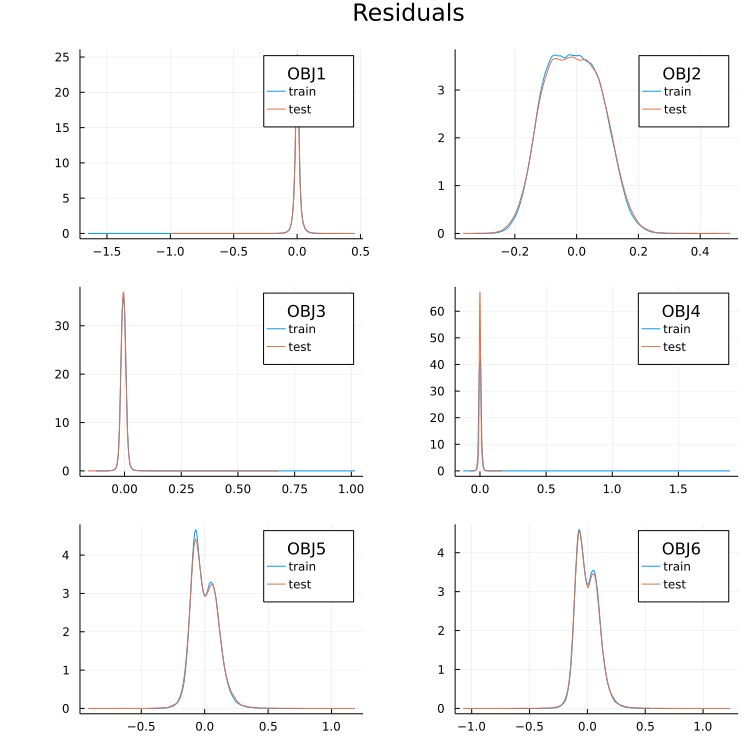

In [23]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

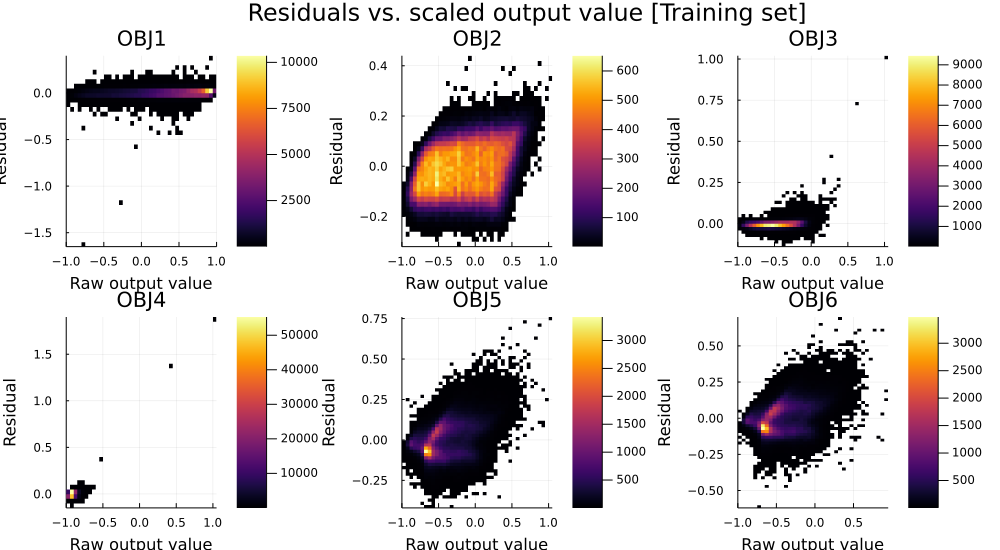

In [24]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

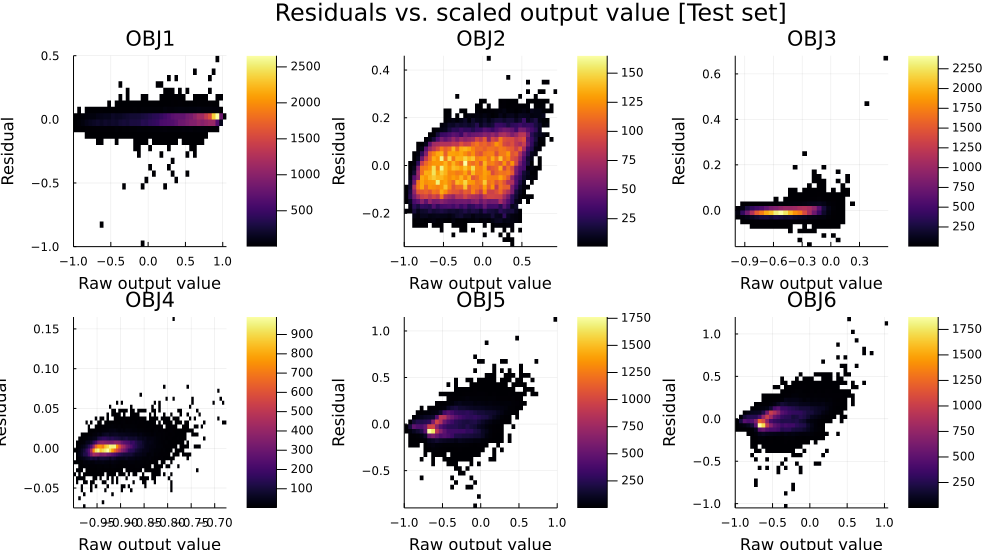

In [25]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")

How can we explain the two-band structure in the residuals of OBJ5 and OBJ6?

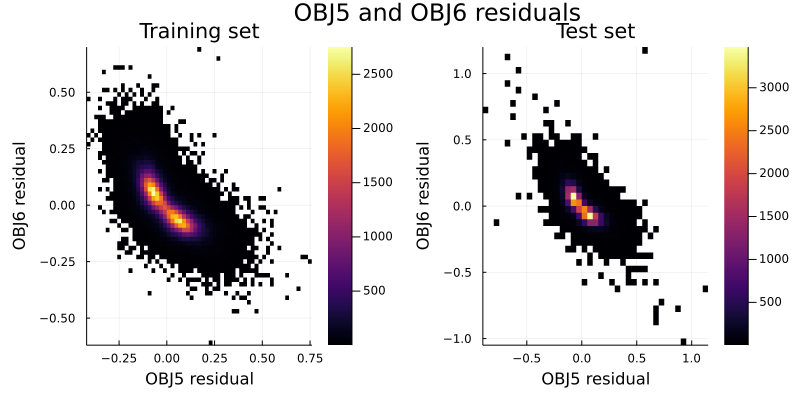

In [26]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    residuals_train[:, 5], residuals_train[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    residuals_test[:, 5], residuals_test[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(800, 400), plot_title="OBJ5 and OBJ6 residuals",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

In [27]:
using Statistics;
println("Correlation between resids for 5 and 6 for train:")
println(Statistics.cor(residuals_train[:, 5], residuals_train[:, 6]))
println("Correlation between resids for 5 and 6 for test:")
println(Statistics.cor(residuals_test[:, 5], residuals_test[:, 6]))

Correlation between resids for 5 and 6 for train:
-0.769269
Correlation between resids for 5 and 6 for test:
-0.7512381


In [28]:
using GLM;

fm = @formula(x6 ~ x5)
linearRegressor = lm(fm, DataFrame(residuals_train))

LoadError: MethodError: no method matching delbeta!(::GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}, ::Vector{Float32})
[0mClosest candidates are:
[0m  delbeta!([91m::GLM.DensePredQR{T}[39m, ::Vector{T}) where T<:Union{Float32, Float64} at ~/.julia/packages/GLM/zj7GL/src/linpred.jl:75
[0m  delbeta!([91m::GLM.DensePredChol{T, <:Cholesky}[39m, ::Vector{T}) where T<:Union{Float32, Float64} at ~/.julia/packages/GLM/zj7GL/src/linpred.jl:129
[0m  delbeta!(::GLM.DensePredChol{T, <:CholeskyPivoted}, [91m::Vector{T}[39m) where T<:Union{Float32, Float64} at ~/.julia/packages/GLM/zj7GL/src/linpred.jl:134
[0m  ...

In [29]:
r2(linearRegressor)

LoadError: UndefVarError: linearRegressor not defined

In [35]:
obj5_train_unscaled = inverse_transform(y_scalers["OBJ5"], y_train[:, 5]);
obj5_test_unscaled = inverse_transform(y_scalers["OBJ5"], y_test[:, 5]);
obj6_train_unscaled = inverse_transform(y_scalers["OBJ6"], y_train[:, 6]);
obj6_test_unscaled = inverse_transform(y_scalers["OBJ6"], y_test[:, 6]);

In [47]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    obj5_train_unscaled, obj6_train_unscaled;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    obj5_test_unscaled, obj6_test_unscaled;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

savefig("../img/obj5obj6trues_comparison.png")

In [37]:
obj5_train_preds_unscaled = inverse_transform(y_scalers["OBJ5"], y_train_preds[:, 5]);
obj5_test_preds_unscaled = inverse_transform(y_scalers["OBJ5"], y_test_preds[:, 5]);
obj6_train_preds_unscaled = inverse_transform(y_scalers["OBJ6"], y_train_preds[:, 6]);
obj6_test_preds_unscaled = inverse_transform(y_scalers["OBJ6"], y_test_preds[:, 6]);

In [46]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    obj5_train_preds_unscaled, obj6_train_preds_unscaled;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="train", legend=true,
    title="Training set predictions", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    obj5_test_preds_unscaled, obj6_test_preds_unscaled;
    xlabel="x-emittance (OBJ5)", ylabel="y-emittance (OBJ6)", label="test", legend=true,
    title="Test set predictions", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

savefig("../img/obj5obj6preds_comparison.png")

In [32]:
# how does the model do at predicting avg(obj5, obj6) ?
# obj5
temp_train_preds_normalized_5 = y_train_preds[:, 5]
temp_train_trues_normalized_5 = y_train[:, 5]

temp_test_preds_normalized_5 = y_test_preds[:, 5]
temp_test_trues_normalized_5 = y_test[:, 5]

# obj6
temp_train_preds_normalized_6 = y_train_preds[:, 6]
temp_train_trues_normalized_6 = y_train[:, 6]

temp_test_preds_normalized_6 = y_test_preds[:, 6]
temp_test_trues_normalized_6 = y_test[:, 6]

# unnormalize
y_scaler_5 = y_scalers["OBJ5"]; y_scaler_6 = y_scalers["OBJ6"]

temp_train_preds_original_5 = inverse_transform(y_scaler_5, temp_train_preds_normalized_5)
temp_train_trues_original_5 = inverse_transform(y_scaler_5, temp_train_trues_normalized_5)
temp_test_preds_original_5 = inverse_transform(y_scaler_5, temp_test_preds_normalized_5)
temp_test_trues_original_5 = inverse_transform(y_scaler_5, temp_test_trues_normalized_5)
temp_train_preds_original_6 = inverse_transform(y_scaler_6, temp_train_preds_normalized_6)
temp_train_trues_original_6 = inverse_transform(y_scaler_6, temp_train_trues_normalized_6)
temp_test_preds_original_6 = inverse_transform(y_scaler_6, temp_test_preds_normalized_6)
temp_test_trues_original_6 = inverse_transform(y_scaler_6, temp_test_trues_normalized_6)

# println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
println(
    "MAPE on test set for mean(OBJ5, OBJ6): ",
    mape(
        (temp_test_preds_original_5 .+ temp_test_preds_original_6) ./ 2,
        (temp_test_trues_original_5 .+ temp_test_trues_original_6) ./ 2
    )
)

MAPE on test set for mean(OBJ5, OBJ6): 0.036858972089740406


In [9]:
# println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
println(
    "MAPE on test set for mean(OBJ5, OBJ6): ",
    mape(
        (temp_test_preds_original_5 .- temp_test_preds_original_6),
        (temp_test_trues_original_5 .- temp_test_trues_original_6)
    )
)

LoadError: UndefVarError: temp_test_preds_original_5 not defined